# Loading the Dataset

In [ ]:
###
# Import libraries
###
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UofG/Winter/DATA 6300/diabetic_data.csv')

In [ ]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


## Checking for the missing values

In [ ]:
# replacing "?" with NA to identify the null values in the database.
df.replace("?", pd.NA, inplace=True)

In [ ]:
#Constructs a bargraph showing the approximate fraction of missing values in the dataset
def features_with_missing_value(df):
  #Here we got the fraction of the missing values in individual column
  feature_nan = df.isna().sum() / df.shape[0]
  feature_nan = feature_nan[feature_nan > 0.0]
  feature_nan = feature_nan.sort_values(ascending=False)

  sns.set_style("whitegrid")
  plt.figure(figsize=(10, 6))
  sns.set(font_scale=1.4)

  # Create a horizontal bar plot
  plt.barh(feature_nan.index, feature_nan.values, color='skyblue', edgecolor='gray')

  # Add labels and a title
  plt.xlabel("Fraction of Missing Values")
  plt.ylabel("Features")
  plt.title("Features with Missing Values")
  plt.gca().invert_yaxis()
  plt.show()

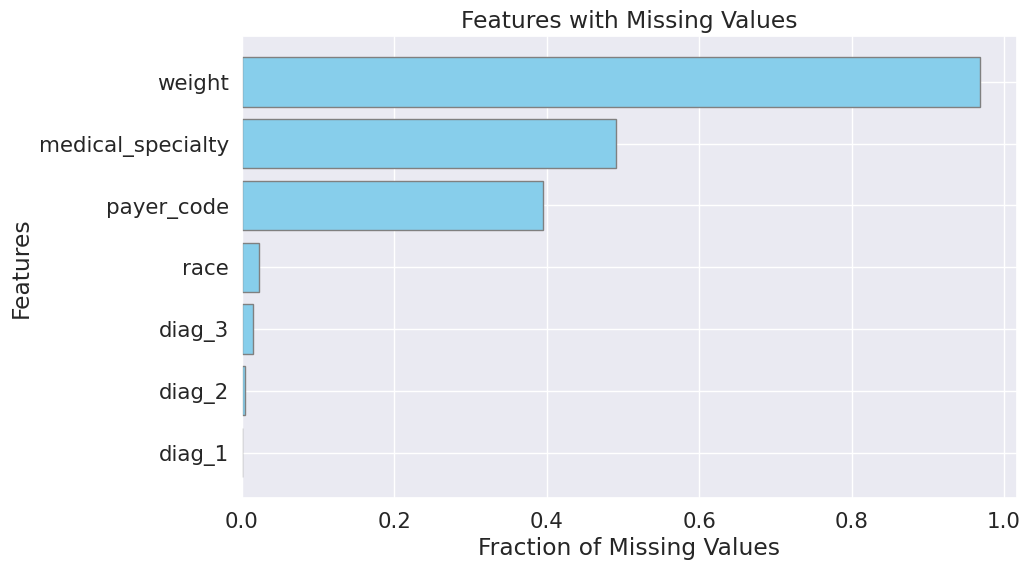

In [ ]:
#checking the columns having empty values
features_with_missing_value(df)

## Handling missing values




As we check the above graph it can be seen that the columns 'weight' , 'medical_specialty', 'prayer_code' have more than 30% empty values hence we would consider to drop them out.

Examining the column types for handling the missing values.

* race : Non ordinal categorical values

* diag_3 : Non ordinal categorical feature

* diag_2 : Non ordinal categorical feature    

* diag_1 : Non ordinal categorical feature.

In [ ]:
df = df.drop(columns=['weight','medical_specialty','payer_code'], axis=1)

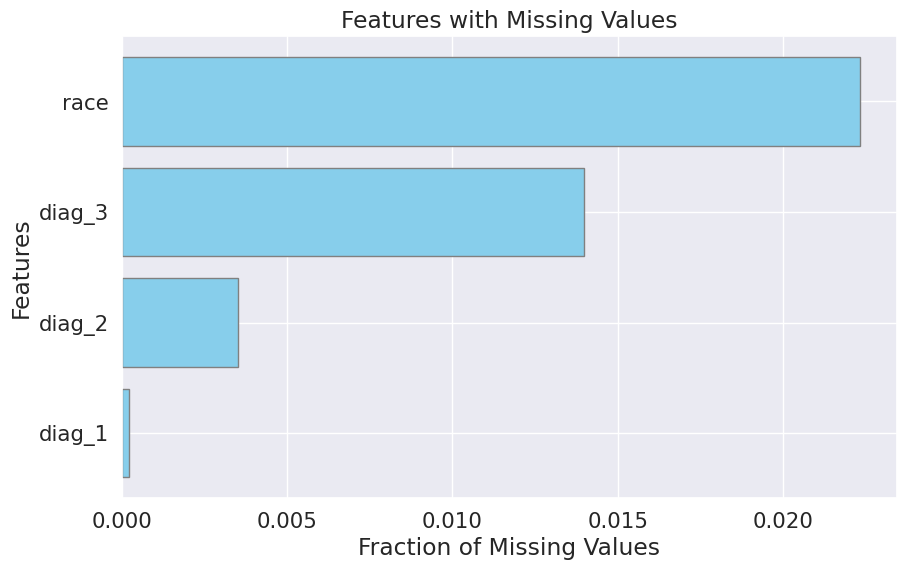

In [ ]:
features_with_missing_value(df)

In [ ]:
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [ ]:
df_b = df.copy()

In [ ]:
df['race'] = df['race'].fillna('other')
# df.isna().sum()

## Removing duplicate rows

In [ ]:
# Find duplicate rows
duplicate_rows = df[df.duplicated()]

# Display duplicate rows
duplicate_rows

# Drop duplicate rows, keeping the first occurrence
df = df.drop_duplicates()

# Optionally, reset the index
df.reset_index(drop=True, inplace=True)

df.shape

(101766, 47)

## Handling Diagnostics Columns

In [ ]:
# Have removed diag columns for to reduce the categorical complexity temprorarily
diag = df[['encounter_id','diag_1', 'diag_2', 'diag_3']].copy()
df = df.drop(columns=['diag_1','diag_2','diag_3'], axis=1)

Mapping the diag columns group-wise according to the ICD-9 table

by refering the table in the following link:
https://www.hindawi.com/journals/bmri/2014/781670/tab2/

Hence here we have reduced categories into just 10 categories.

In [ ]:
# Have reffered the following function from a blog which helped me to lower the number of categories
def map_diagnosis(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data["temp_diag"] = np.nan
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), "temp_diag"] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), "temp_diag"] = "Digestive"
        data.loc[(data[col]>=250) & (data[col]<251), "temp_diag"] = "Diabetes"
        data.loc[(data[col]>=800) & (data[col]<=999), "temp_diag"] = "Injury"
        data.loc[(data[col]>=710) & (data[col]<=739), "temp_diag"] = "Muscoloskeletal"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), "temp_diag"] = "Genitourinary"
        data.loc[(data[col]>=140) & (data[col]<=239), "temp_diag"] = "Neoplasms"

        data["temp_diag"] = data["temp_diag"].fillna("Other")
        data[col] = data["temp_diag"]
        data = data.drop("temp_diag", axis=1)

    return data

In [ ]:
# Calculate mode for each column
mode_diag_1 = diag['diag_1'].mode()[0]  # Mode of diag_1 column
mode_diag_2 = diag['diag_2'].mode()[0]  # Mode of diag_2 column
mode_diag_3 = diag['diag_3'].mode()[0]  # Mode of diag_3 column

# Impute missing values with mode values
diag['diag_1'].fillna(mode_diag_1, inplace=True)
diag['diag_2'].fillna(mode_diag_2, inplace=True)
diag['diag_3'].fillna(mode_diag_3, inplace=True)

# Display the DataFrame after imputation
diag


,encounter_id,diag_1,diag_2,diag_3
0,2278392,250.83,276,250
1,149190,276,250.01,255
2,64410,648,250,V27
3,500364,8,250.43,403
4,16680,197,157,250
...,...,...,...,...
101761,443847548,250.13,291,458
101762,443847782,560,276,787
101763,443854148,38,590,296
101764,443857166,996,285,998


In [ ]:
# mapping the diagnostics table
diagnostics = map_diagnosis(diag,["diag_1","diag_2","diag_3"])

In [ ]:
diagnostics

,encounter_id,diag_1,diag_2,diag_3
0,2278392,Diabetes,Other,Diabetes
1,149190,Other,Diabetes,Other
2,64410,Other,Diabetes,Other
3,500364,Other,Diabetes,Circulatory
4,16680,Neoplasms,Neoplasms,Diabetes
...,...,...,...,...
101761,443847548,Diabetes,Other,Circulatory
101762,443847782,Digestive,Other,Digestive
101763,443854148,Other,Genitourinary,Other
101764,443857166,Injury,Other,Injury


In [ ]:
# One-hot encode the specified columns
en_diagnostics = pd.get_dummies(diagnostics, columns=['diag_1', 'diag_2', 'diag_3'])
en_diagnostics

,encounter_id,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory
0,2278392,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,149190,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,64410,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,500364,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,16680,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
101762,443847782,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
101763,443854148,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
101764,443857166,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
df = pd.merge(df, en_diagnostics, on='encounter_id', how='inner')

df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,0,16,0,0,0,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
101762,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,3,18,0,0,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
101763,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,0,9,1,0,0,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
101764,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,2,21,0,0,1,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


Now as there are no missing values left as all the empty columns have been handled.

Now we would be focusing on the feature engineering and taking care of categorical columns to reduce dimensionality complexity.

# Feature Engineering

## Handling Categorical Values

In [ ]:
# Bifurcating the numerical and categorical column
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [ ]:
print(numerical_columns)
print(len(numerical_columns))

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'diag_1_Circulatory', 'diag_1_Diabetes',
       'diag_1_Digestive', 'diag_1_Genitourinary', 'diag_1_Injury',
       'diag_1_Muscoloskeletal', 'diag_1_Neoplasms', 'diag_1_Other',
       'diag_1_Respiratory', 'diag_2_Circulatory', 'diag_2_Diabetes',
       'diag_2_Digestive', 'diag_2_Genitourinary', 'diag_2_Injury',
       'diag_2_Muscoloskeletal', 'diag_2_Neoplasms', 'diag_2_Other',
       'diag_2_Respiratory', 'diag_3_Circulatory', 'diag_3_Diabetes',
       'diag_3_Digestive', 'diag_3_Genitourinary', 'diag_3_Injury',
       'diag_3_Muscoloskeletal', 'diag_3_Neoplasms', 'diag_3_Other',
       'diag_3_Respiratory'],
      dtype='object')
40


In [ ]:
print(categorical_columns)
print(len(categorical_columns))

Index(['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
31


In [ ]:
# Function to check the unique categories for the categorical features.
def check_feature_categories():
  for column in df.select_dtypes(include=['object']).columns:
      # Check if the column type is object (categorical)
      if df[column].dtype == 'object':
          # Get the unique categories in the column
          unique_categories = df[column].unique()
          # Print column name and its unique categories
          print(f"Column: {column}")
          for category in unique_categories:
              print(f"- {category}")


In [ ]:
check_feature_categories()

Column: race
- Caucasian
- AfricanAmerican
- other
- Other
- Asian
- Hispanic
Column: gender
- Female
- Male
- Unknown/Invalid
Column: age
- [0-10)
- [10-20)
- [20-30)
- [30-40)
- [40-50)
- [50-60)
- [60-70)
- [70-80)
- [80-90)
- [90-100)
Column: max_glu_serum
- None
- >300
- Norm
- >200
Column: A1Cresult
- None
- >7
- >8
- Norm
Column: metformin
- No
- Steady
- Up
- Down
Column: repaglinide
- No
- Up
- Steady
- Down
Column: nateglinide
- No
- Steady
- Down
- Up
Column: chlorpropamide
- No
- Steady
- Down
- Up
Column: glimepiride
- No
- Steady
- Down
- Up
Column: acetohexamide
- No
- Steady
Column: glipizide
- No
- Steady
- Up
- Down
Column: glyburide
- No
- Steady
- Up
- Down
Column: tolbutamide
- No
- Steady
Column: pioglitazone
- No
- Steady
- Up
- Down
Column: rosiglitazone
- No
- Steady
- Up
- Down
Column: acarbose
- No
- Steady
- Up
- Down
Column: miglitol
- No
- Steady
- Down
- Up
Column: troglitazone
- No
- Steady
Column: tolazamide
- No
- Steady
- Up
Column: examide
- No
Colum

Target column : Readmitted ,
To check if the patient was readmitted or not.

Class :    
 * NO
 * in less than 30 days
 * in greater than 30 days

In [ ]:
# Here we have considered dealing with all the medicinal drugs
medicines = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
medicinal_df = df[medicines].copy()

In [ ]:
#Mapping the categories to a numerical value
mapping_medicenes = {'Down': -1, 'No': 0, 'Steady': 1, 'Up': 2}

for col in medicines:
  df[col] = df[col].map(mapping_medicenes)
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,No,No,NO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,2,0,0,0,0,0,Ch,Yes,>30,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,No,Yes,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,2,0,0,0,0,0,Ch,Yes,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,NO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,0,16,0,0,0,9,None,>8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,-1,0,0,0,0,0,Ch,Yes,>30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
101762,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,3,18,0,0,1,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,No,Yes,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
101763,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,0,9,1,0,0,13,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,-1,0,0,0,0,0,Ch,Yes,NO,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
101764,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,2,21,0,0,1,9,None,None,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,No,No,2,0,0,0,0,0,Ch,Yes,NO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Function for encoding the categorical features into numerical values.
def replace_age_ranges(feature):
  age_ranges = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)','[60-70)', '[70-80)', '[80-90)', '[90-100)']
  values = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

  # The function iterates through the age_ranges and replaces each occurrence in the 'feature' with the corresponding numerical value.
  for i, age_range in enumerate(age_ranges):
    feature = feature.replace(age_range, values[i])

  return feature

In [ ]:
df['age']=replace_age_ranges(df['age'])

In [ ]:
df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [ ]:
# Find rows where 'gender' column has value 'Unknown/Invalid'
invalid_gender_rows = list(df[df['gender'] == 'Unknown/Invalid'].index)

# Print the rows with invalid gender
invalid_gender_rows

[30506, 75551, 82573]

In [ ]:
# Dropping the rows with the unkown/invalid gender.
df = df.drop(invalid_gender_rows)

In [ ]:
# Changing the value of 'other' to 'Other' in the dataframe.
df['race'] = df['race'].replace('other', 'Other')

In [ ]:
# Changing the value of 'Ch' to 'Yes' in the for Change feature in dataframe.
df['change'] = df['change'].replace('Ch', 'Yes')

In [ ]:
# Droping columns 'examide' , 'citoglipton' as there is only one category present in the column
df = df.drop(columns = ['examide','citoglipton'], axis=1)

In [ ]:
check_feature_categories()

Column: race
- Caucasian
- AfricanAmerican
- Other
- Asian
- Hispanic
Column: gender
- Female
- Male
Column: max_glu_serum
- None
- >300
- Norm
- >200
Column: A1Cresult
- None
- >7
- >8
- Norm
Column: change
- No
- Yes
Column: diabetesMed
- No
- Yes
Column: readmitted
- NO
- >30
- <30


The following columns have non-ordinal relationship categories hence one hot label encoding has been considered to encode the categorical values.
Column: race
- Caucasian
- AfricanAmerican
- Other
- Asian
- Hispanic

Column: gender
- Female
- Male

In [ ]:
df = pd.get_dummies(df, columns=['race','gender'])

In [ ]:
df_b = df.copy()

In [ ]:
# Changing the categorical colums with Yes as 1 and No as 0 in the columns having binary categories
df['change'] = df['change'].replace('Ch', 'Yes')


In [ ]:
df['change'] = df['change'].apply(lambda x: 0 if x == 'No' else 1)
df['diabetesMed'] = df['diabetesMed'].apply(lambda x: 0 if x == 'No' else 1)

In [ ]:
df

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male
0,2278392,8222157,5,6,25,1,1,41,0,1,0,0,0,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,149190,55629189,15,1,1,7,3,59,0,18,0,0,0,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,>30,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,64410,86047875,25,1,1,7,2,11,5,13,2,0,1,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,500364,82442376,35,1,1,7,2,44,1,16,0,0,0,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,16680,42519267,45,1,1,7,1,51,0,8,0,0,0,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,75,1,3,7,3,51,0,16,0,0,0,9,None,>8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,>30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
101762,443847782,74694222,85,1,4,5,5,33,3,18,0,0,1,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
101763,443854148,41088789,75,1,1,7,1,53,0,9,1,0,0,13,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
101764,443857166,31693671,85,2,3,7,10,45,2,21,0,0,1,9,None,None,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Handling the values of max_glu_serum
mapping_max_glu_serum = {'None': 0, 'Norm': 1, '>200': 2, '>300': 2}
df['max_glu_serum'] = df['max_glu_serum'].map(mapping_max_glu_serum)
df

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male
0,2278392,8222157,5,6,25,1,1,41,0,1,0,0,0,1,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,149190,55629189,15,1,1,7,3,59,0,18,0,0,0,9,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,>30,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,64410,86047875,25,1,1,7,2,11,5,13,2,0,1,6,0,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,500364,82442376,35,1,1,7,2,44,1,16,0,0,0,7,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,16680,42519267,45,1,1,7,1,51,0,8,0,0,0,5,0,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,75,1,3,7,3,51,0,16,0,0,0,9,0,>8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,>30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
101762,443847782,74694222,85,1,4,5,5,33,3,18,0,0,1,9,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
101763,443854148,41088789,75,1,1,7,1,53,0,9,1,0,0,13,0,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
101764,443857166,31693671,85,2,3,7,10,45,2,21,0,0,1,9,0,None,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Label encoding the values of the A1Cresult
mapping_A1Cresult = {'None': 0, 'Norm': 1, '>7': 2, '>8': 2}
df['A1Cresult'] = df['A1Cresult'].map(mapping_A1Cresult)
df

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male
0,2278392,8222157,5,6,25,1,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,149190,55629189,15,1,1,7,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,>30,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,64410,86047875,25,1,1,7,2,11,5,13,2,0,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,500364,82442376,35,1,1,7,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,16680,42519267,45,1,1,7,1,51,0,8,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,75,1,3,7,3,51,0,16,0,0,0,9,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,>30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
101762,443847782,74694222,85,1,4,5,5,33,3,18,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
101763,443854148,41088789,75,1,1,7,1,53,0,9,1,0,0,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,NO,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
101764,443857166,31693671,85,2,3,7,10,45,2,21,0,0,1,9,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,1,NO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


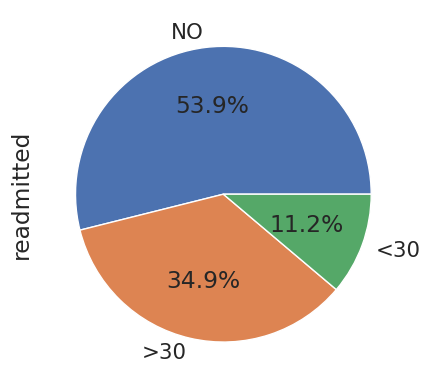

In [ ]:
df['readmitted'].value_counts()/len(df)
counts = df['readmitted'].value_counts()

percentages = counts * 100 / len(df)

fig, ax = plt.subplots()
percentages.plot(kind='pie', ax=ax, autopct='%1.1f%%')
plt.show()

In [ ]:
# Label encoding the values of the A1Cresult
mapping_readmitted = {'NO': 0 , '<30': 1, '>30': 1}
df['readmitted'] = df['readmitted'].map(mapping_readmitted)
df

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Muscoloskeletal,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,diag_2_Circulatory,diag_2_Diabetes,diag_2_Digestive,diag_2_Genitourinary,diag_2_Injury,diag_2_Muscoloskeletal,diag_2_Neoplasms,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Other,diag_3_Respiratory,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male
0,2278392,8222157,5,6,25,1,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,149190,55629189,15,1,1,7,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,64410,86047875,25,1,1,7,2,11,5,13,2,0,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,500364,82442376,35,1,1,7,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,16680,42519267,45,1,1,7,1,51,0,8,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,75,1,3,7,3,51,0,16,0,0,0,9,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
101762,443847782,74694222,85,1,4,5,5,33,3,18,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
101763,443854148,41088789,75,1,1,7,1,53,0,9,1,0,0,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
101764,443857166,31693671,85,2,3,7,10,45,2,21,0,0,1,9,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


Here we would be removing the irrelevant columns from the data frame like encounter_id and patient_id.

In [ ]:
df['readmitted'].value_counts()

0    54861
1    46902
Name: readmitted, dtype: int64

In [ ]:
df = df.drop(columns = ['encounter_id','patient_nbr'], axis=1)

## Handling Numerical Features

In [ ]:
list(numerical_columns)

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'diag_1_Circulatory',
 'diag_1_Diabetes',
 'diag_1_Digestive',
 'diag_1_Genitourinary',
 'diag_1_Injury',
 'diag_1_Muscoloskeletal',
 'diag_1_Neoplasms',
 'diag_1_Other',
 'diag_1_Respiratory',
 'diag_2_Circulatory',
 'diag_2_Diabetes',
 'diag_2_Digestive',
 'diag_2_Genitourinary',
 'diag_2_Injury',
 'diag_2_Muscoloskeletal',
 'diag_2_Neoplasms',
 'diag_2_Other',
 'diag_2_Respiratory',
 'diag_3_Circulatory',
 'diag_3_Diabetes',
 'diag_3_Digestive',
 'diag_3_Genitourinary',
 'diag_3_Injury',
 'diag_3_Muscoloskeletal',
 'diag_3_Neoplasms',
 'diag_3_Other',
 'diag_3_Respiratory']

In [ ]:
df[df.select_dtypes(include=['number']).columns].shape

(101763, 72)

# Modelling

## Handling the class imbalance in the dataframe

In [ ]:
## dropping the readmitted column to get the feature columns for train dataset
X = df.drop('readmitted', axis = 1)
## target column
y = df['readmitted']

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

## Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Initialize logistic regression model
lrm = LogisticRegression()

# Train the model
# logistic_model.fit(X_resampled, y_resampled)
lrm.fit(X_train, y_train)

# Make predictions
y_pred = lrm.predict(X_test)

# Evaluate model performance
lr_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", lr_accuracy)

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.6208912691003783
              precision    recall  f1-score   support

           0       0.62      0.80      0.70     11016
           1       0.63      0.41      0.50      9337

    accuracy                           0.62     20353
   macro avg       0.62      0.60      0.60     20353
weighted avg       0.62      0.62      0.61     20353



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

dt = DecisionTreeClassifier()

# For classification
dt.fit(X_resampled, y_resampled)

# For classification
y_pred = dt.predict(X_test)

# For classification
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dt_accuracy)
print(classification_report(y_test, y_pred))



Accuracy: 0.5646833390654941
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     11016
           1       0.52      0.54      0.53      9337

    accuracy                           0.56     20353
   macro avg       0.56      0.56      0.56     20353
weighted avg       0.57      0.56      0.57     20353



In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Display cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.56408941 0.56545786 0.56004105 0.56642719 0.57207207]
Mean CV Accuracy: 0.5656175162504277


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the model
rfc = RandomForestClassifier()

# Train the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred = rfc.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.6426079693411291
              precision    recall  f1-score   support

           0       0.65      0.74      0.69     11016
           1       0.63      0.53      0.58      9337

    accuracy                           0.64     20353
   macro avg       0.64      0.63      0.63     20353
weighted avg       0.64      0.64      0.64     20353



In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(rfc, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Display cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.63028852 0.63507812 0.63063063 0.63194207 0.61506443]
Mean CV Accuracy: 0.6286007526513855


## Support Vector Machines

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the model
svc = SVC()

# Train the model
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
svc_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", svc_accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.6107207782636467
              precision    recall  f1-score   support

           0       0.59      0.90      0.71     11016
           1       0.70      0.27      0.39      9337

    accuracy                           0.61     20353
   macro avg       0.64      0.58      0.55     20353
weighted avg       0.64      0.61      0.56     20353



## Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming X contains features and y contains the target variable
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate base classifier (e.g., Decision Tree)
base_classifier = DecisionTreeClassifier()

# Instantiate BaggingClassifier
bagging_model = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

# Train the model
bagging_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bagging_model.predict(X_test)

# Evaluate model performance
bc_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", bc_accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.6059548960841153
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     11016
           1       0.59      0.47      0.52      9337

    accuracy                           0.61     20353
   macro avg       0.60      0.60      0.59     20353
weighted avg       0.60      0.61      0.60     20353



In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming X contains features and y contains the target variable
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate base classifier (e.g., Decision Tree)
base_classifier = DecisionTreeClassifier()

# Instantiate BaggingClassifier
bagging_model = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

# Train the model
bagging_model.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = bagging_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.6006976858448386
              precision    recall  f1-score   support

           0       0.62      0.70      0.65     11016
           1       0.58      0.48      0.53      9337

    accuracy                           0.60     20353
   macro avg       0.60      0.59      0.59     20353
weighted avg       0.60      0.60      0.60     20353



## Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
nn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", nn_accuracy)

print(classification_report(y_test, y_pred))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2021/2036 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5375

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2036/2036 [==============================] - 10s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5377 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 2/10
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5376 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 3/10
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5376 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 4/10
2036/2036 [==============================] - 7s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5376 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 5/10
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5376 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 6/10
2036/2036 [==============================] - 9s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5376 - val_loss: 0.0000e+00 - val_accuracy: 0.5424
Epoch 7/10
2036/2036 [==============================] - 7s 3ms/step - loss: 0.0000e+00 - accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2178/2193 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5385

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2193/2193 [==============================] - 9s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5382 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 2/10
2193/2193 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5383 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 3/10
2193/2193 [==============================] - 7s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5383 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 4/10
2193/2193 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5383 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 5/10
2193/2193 [==============================] - 7s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5383 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 6/10
2193/2193 [==============================] - 8s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5383 - val_loss: 0.0000e+00 - val_accuracy: 0.3469
Epoch 7/10
2193/2193 [==============================] - 9s 4ms/step - loss: 0.0000e+00 - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import MinMaxScaler

# Instantiate the model
bnb = BernoulliNB()

# Train the model
bnb.fit(X_train, y_train)

# Make predictions
y_pred = bnb.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", nb_accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.6228565813393603
              precision    recall  f1-score   support

           0       0.63      0.73      0.68     11016
           1       0.61      0.50      0.55      9337

    accuracy                           0.62     20353
   macro avg       0.62      0.61      0.61     20353
weighted avg       0.62      0.62      0.62     20353



## Gradient Boosting Machine (GBM) : XGB Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the model
xgb_clf = XGBClassifier()

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", xgb_accuracy)

print(classification_report(y_test, y_pred))


## CatBoos

In [ ]:
# pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Instantiate CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass')

# Train the model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

# Make predictions on the test data
y_pred = catboost_model.predict(X_test)

# Evaluate model performance
cat_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", cat_accuracy)

print(classification_report(y_test, y_pred))


## Plotting the graph for model performance